# Quantum Convolutional Neural Network Project

## 1. Introduction

In this project, I explore the implementation of a Quantum Convolutional Neural Network (QCNN), inspired by the work of Cong et al. [1]. Using Qiskit, I model both the convolutional and pooling layers as quantum circuits. The goal is to construct and train a QCNN capable of distinguishing between horizontal and vertical lines in pixelated images. This notebook documents the step-by-step process, from building the network to training and evaluation.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

## 1.1 Classical Convolutional Neural Networks (CCNNs)

In my project, I started by exploring Classical Convolutional Neural Networks (CCNNs), which are widely used in image recognition and audio processing due to their ability to extract features and patterns from input data. CCNNs achieve this through two main types of layers: convolutional layers and pooling layers.

To illustrate, imagine training a CCNN to distinguish between images of cats and dogs. The input image is processed through a series of alternating convolutional (C) and pooling (P) layers. Each convolutional layer uses kernels to detect specific patterns or features in the image, while pooling layers reduce the dimensionality of the data, making the network more efficient and reducing the number of parameters.

After passing through these layers, the data reaches a fully connected (FC) layer, which produces the final output—indicating whether the image is a cat or a dog. This layered approach allows the network to learn and associate features with specific outputs during training, making CCNNs powerful tools for pattern recognition tasks.

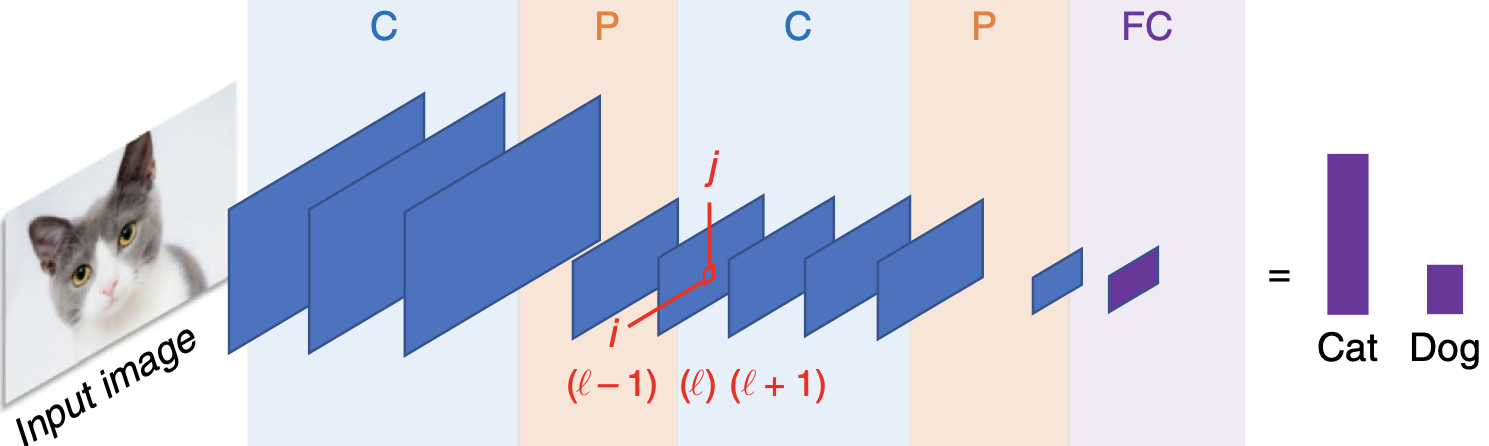
Figure 1. This schematic illustrates how a Classical Convolutional Neural Network (CCNN) can be used to classify images, such as distinguishing between cats and dogs. In my project, I use a similar approach: the input image passes through multiple convolutional and pooling layers, with pooling progressively reducing the data's dimensionality. The final output layer predicts whether the input image is a cat or a dog. This process forms the foundation for my exploration of quantum analogues later in the notebook. Image adapted from [1].

## 1.2 Quantum Convolutional Neural Networks (QCNNs)

In my project, I explored Quantum Convolutional Neural Networks (QCNNs), which operate in a manner analogous to their classical counterparts. I began by encoding pixelated images into quantum circuits using feature maps available in Qiskit, such as the ZFeatureMap.

Once the image data was encoded, I applied alternating quantum convolutional and pooling layers. These layers progressively reduced the dimensionality of the quantum circuit until only a single qubit remained. The classification of the input image was then performed by measuring this final qubit.

For the quantum convolutional layers, I used two-qubit unitary operators to capture and analyze relationships between qubits—these gates are defined in detail in the following section. Unlike classical pooling, quantum pooling reduces the number of active qubits by ceasing operations on specific qubits at certain layers, effectively "pooling" by omission rather than aggregation. The specifics of this pooling approach are discussed further in the next section.

Each layer in my QCNN implementation contained parameterized quantum circuits. During training, these parameters were optimized to minimize the loss function, allowing the QCNN to learn from the data.

Below, I provide a simple example of a four-qubit QCNN circuit to illustrate this architecture.
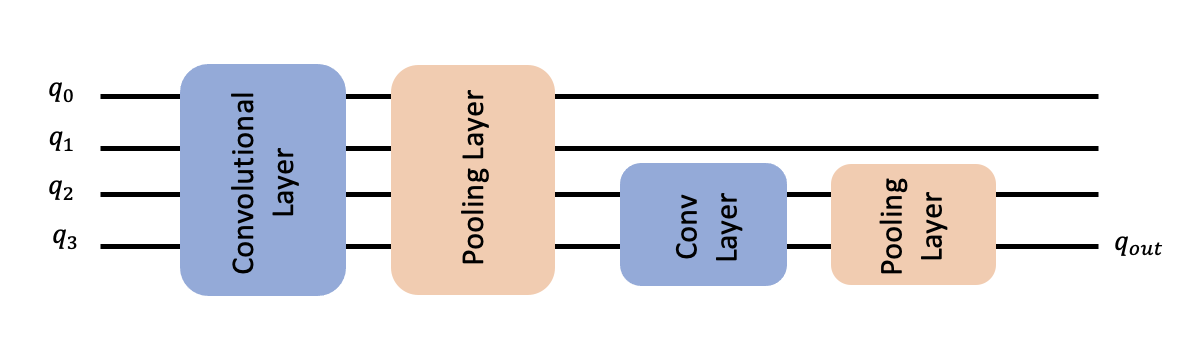

Unitary parameterized gate

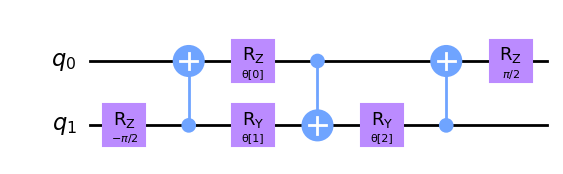

In [2]:
#defining a two qubit unitary 
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

#Drawing the circuit

params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw('mpl', style="clifford")


Convolutional layer

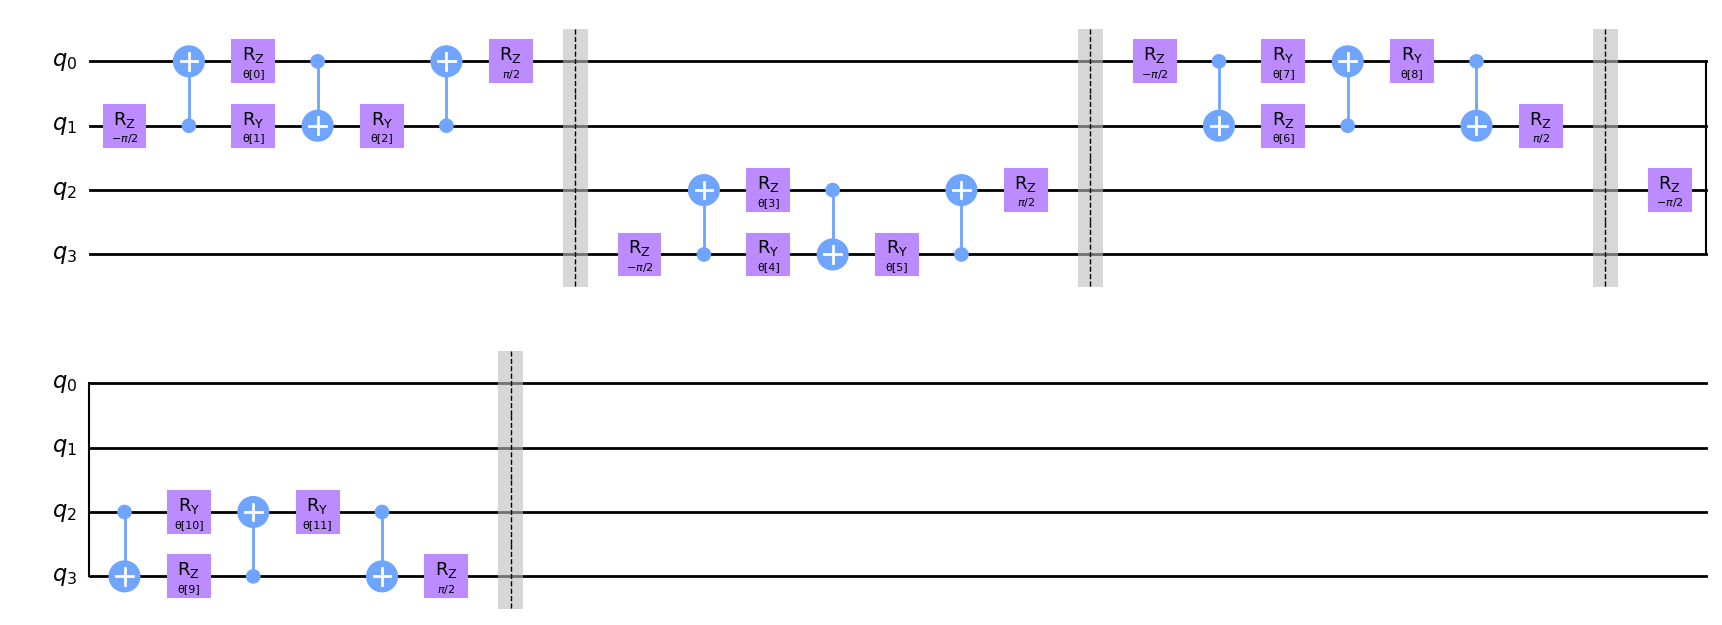

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params =  ParameterVector(param_prefix, length=3 * num_qubits)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index:param_index + 3]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[0::2]):
        qc = qc.compose(conv_circuit(params[param_index:param_index + 3]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc= QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw('mpl', style="clifford")


Unitary pooling circuit


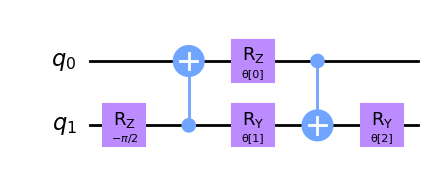

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    
    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw('mpl', style="clifford")

Pooling layer

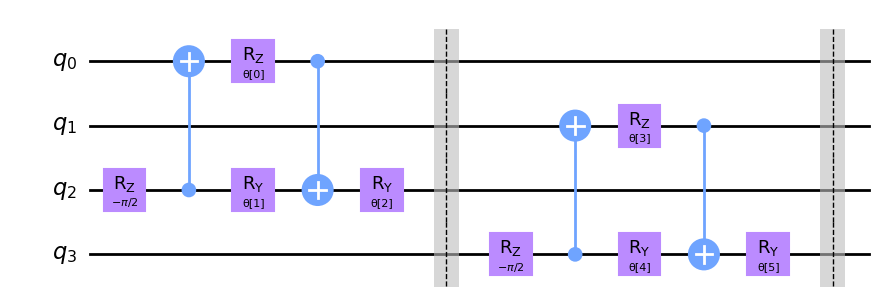

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3 )
    for q1, q2 in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index:param_index + 3]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc= QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw('mpl', style="clifford")

Data generation


In [6]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1
    
    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 1] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif  rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        #Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [7]:
images, labels = generate_dataset(1000)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=246)

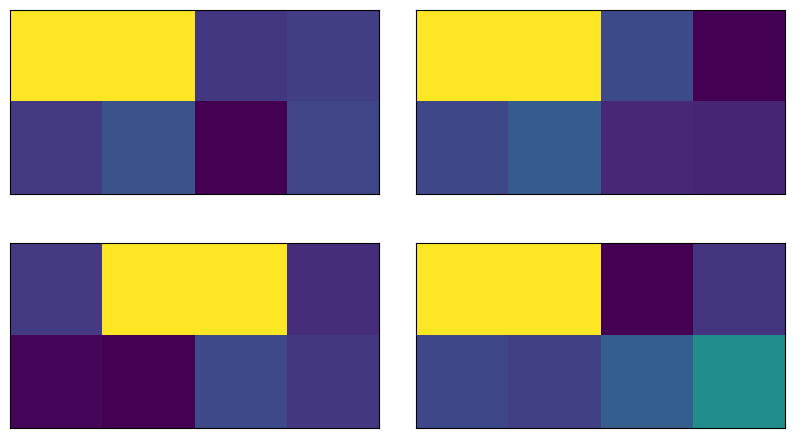

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

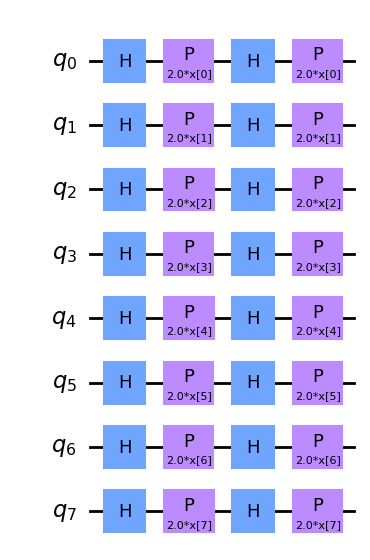

In [9]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [10]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


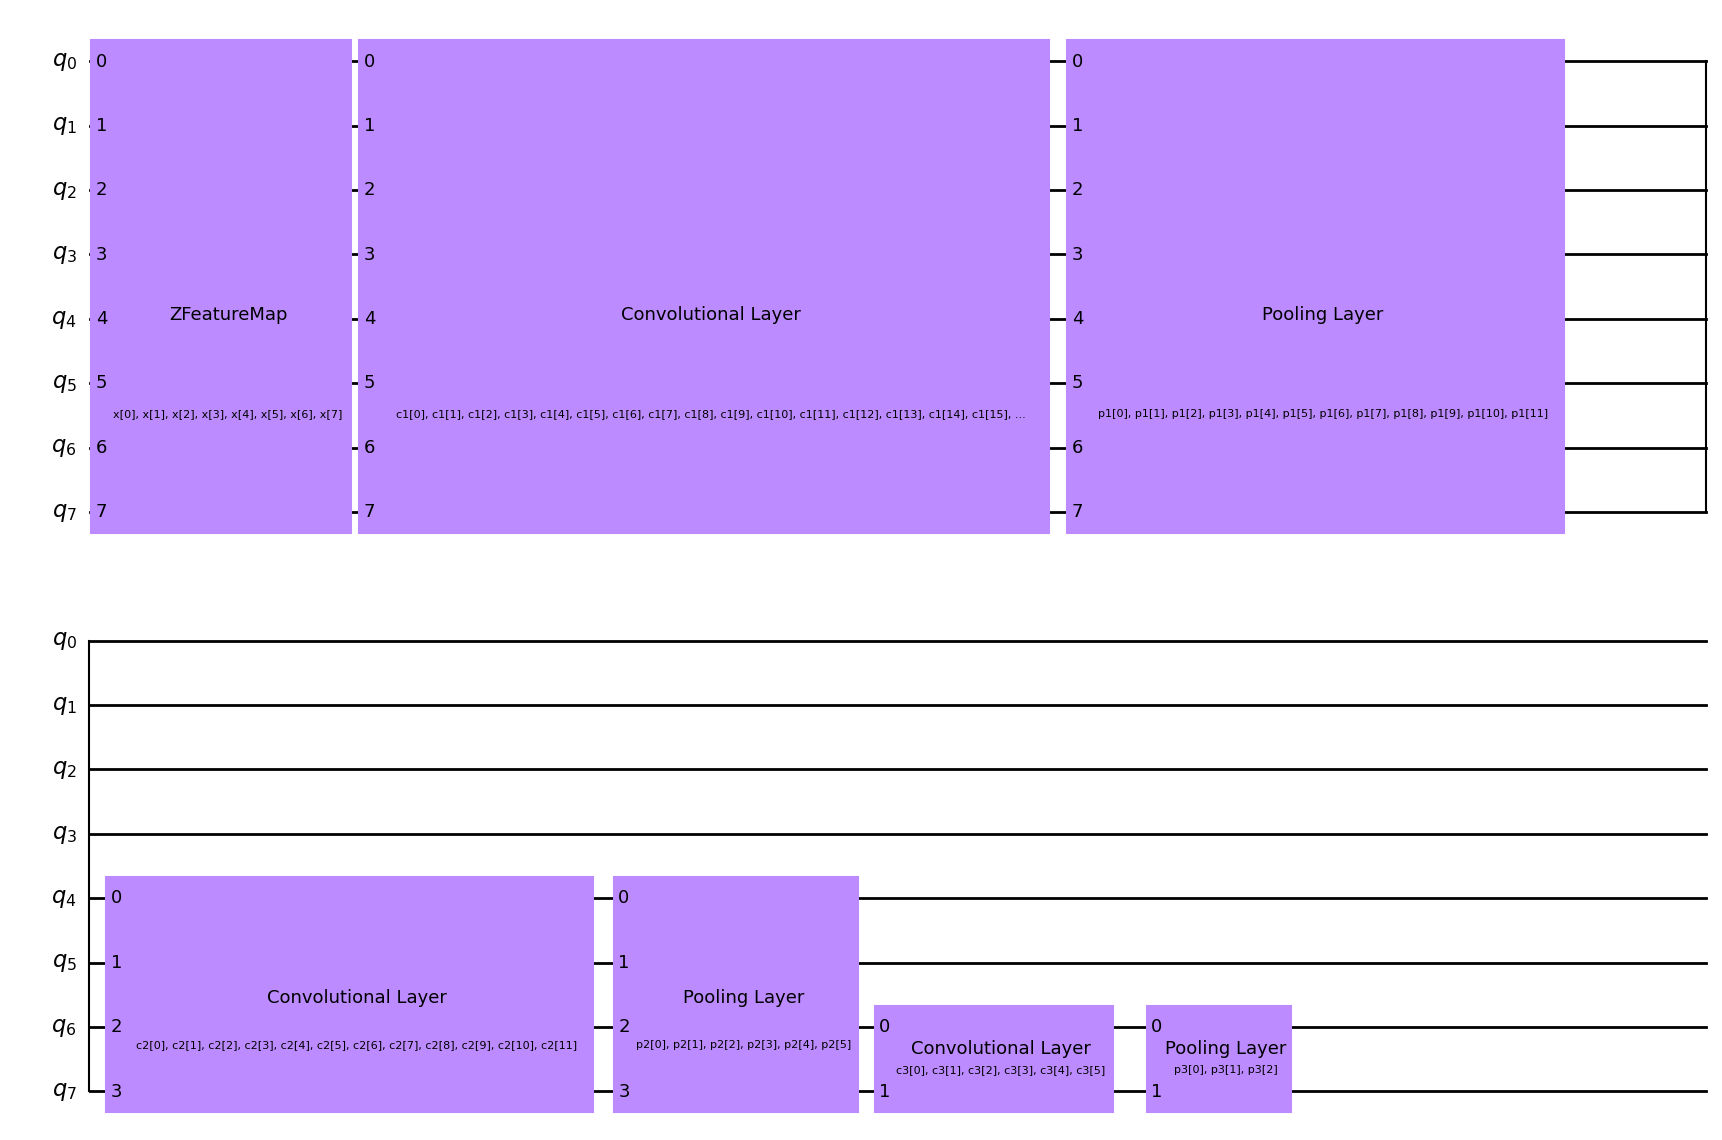

In [11]:
circuit.draw("mpl", style="clifford")

In [12]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)